In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet, UNet_conditional
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))
types = torch.tensor([all_types.index(t[0]) for t in types], device=device)

#contour = load_contour().to(device)
#contour.shape

In [4]:
T = 100
beta = torch.linspace(0.09, 0.05, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0007, device='cuda:0')

In [5]:
alpha_

tensor([9.1000e-01, 8.2847e-01, 7.5458e-01, 6.8758e-01, 6.2681e-01, 5.7166e-01,
        5.2160e-01, 4.7613e-01, 4.3482e-01, 3.9726e-01, 3.6312e-01, 3.3205e-01,
        3.0377e-01, 2.7803e-01, 2.5458e-01, 2.3321e-01, 2.1373e-01, 1.9596e-01,
        1.7975e-01, 1.6495e-01, 1.5144e-01, 1.3910e-01, 1.2781e-01, 1.1750e-01,
        1.0806e-01, 9.9428e-02, 9.1524e-02, 8.4285e-02, 7.7653e-02, 7.1574e-02,
        6.6000e-02, 6.0887e-02, 5.6194e-02, 5.1886e-02, 4.7929e-02, 4.4293e-02,
        4.0951e-02, 3.7878e-02, 3.5050e-02, 3.2448e-02, 3.0052e-02, 2.7845e-02,
        2.5812e-02, 2.3937e-02, 2.2208e-02, 2.0613e-02, 1.9141e-02, 1.7782e-02,
        1.6527e-02, 1.5366e-02, 1.4294e-02, 1.3302e-02, 1.2384e-02, 1.1535e-02,
        1.0748e-02, 1.0020e-02, 9.3448e-03, 8.7190e-03, 8.1386e-03, 7.6001e-03,
        7.1004e-03, 6.6363e-03, 6.2053e-03, 5.8048e-03, 5.4324e-03, 5.0862e-03,
        4.7641e-03, 4.4643e-03, 4.1851e-03, 3.9252e-03, 3.6829e-03, 3.4571e-03,
        3.2465e-03, 3.0501e-03, 2.8668e-

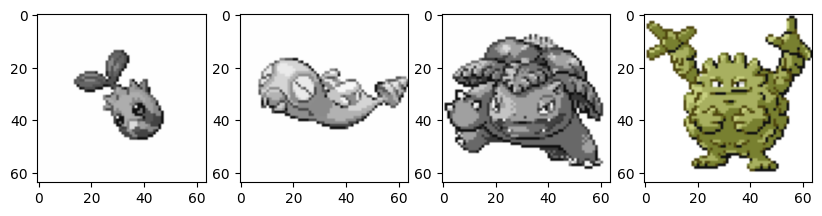

In [6]:
transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [7]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [8]:
model = UNet_conditional(3, 3, num_classes=len(all_types)).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 64, 64), device=device)
    h = torch.tensor([0.2, 0.5, 1.0], device=device)
    h = h[torch.randperm(3)]

    ty = ["Grass", "Fire", "Water"]
    ty = torch.tensor([all_types.index(t) for t in ty], device=device)
    #print(ty)

    for t in reversed(range(T)):
        tt = torch.tensor(t, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, h, ty) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [9]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

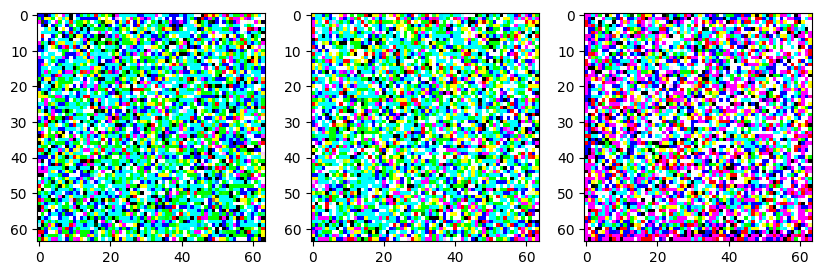

0.05799271:   1%|          | 999/100001 [01:26<2:21:04, 11.70it/s]

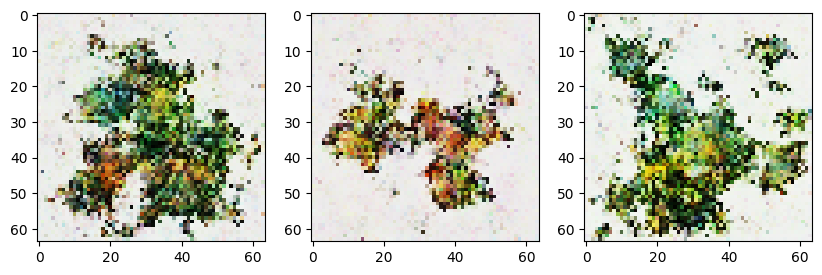

0.06633654:   2%|▏         | 1999/100001 [02:54<2:19:44, 11.69it/s]

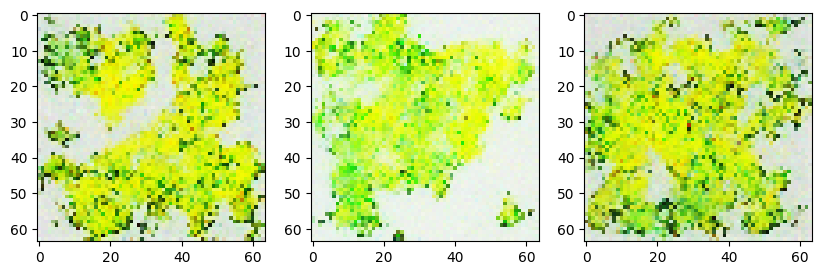

0.03110082:   3%|▎         | 2999/100001 [04:21<2:18:06, 11.71it/s]

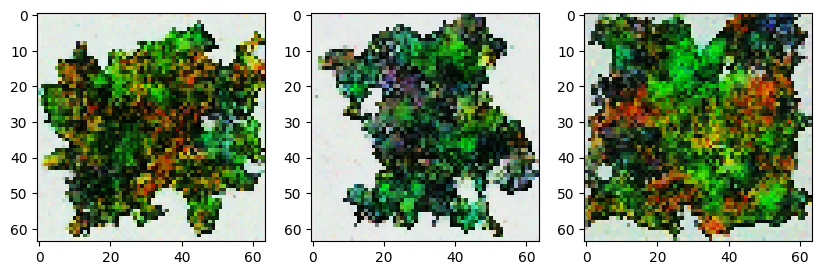

0.05600969:   4%|▍         | 3999/100001 [05:47<2:16:26, 11.73it/s]

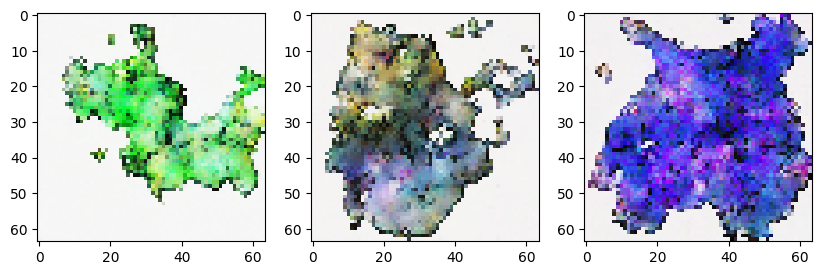

0.03020394:   5%|▍         | 4999/100001 [07:14<2:15:44, 11.66it/s]

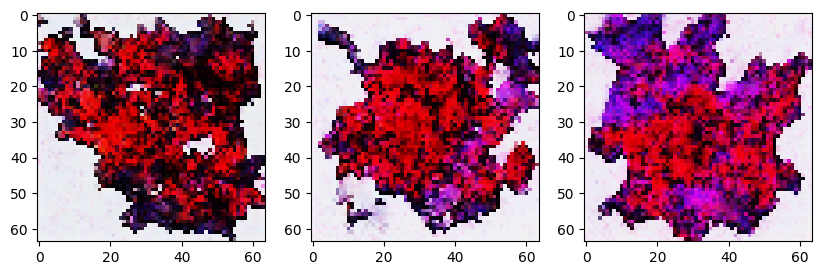

0.02543562:   6%|▌         | 5999/100001 [08:41<2:13:41, 11.72it/s]

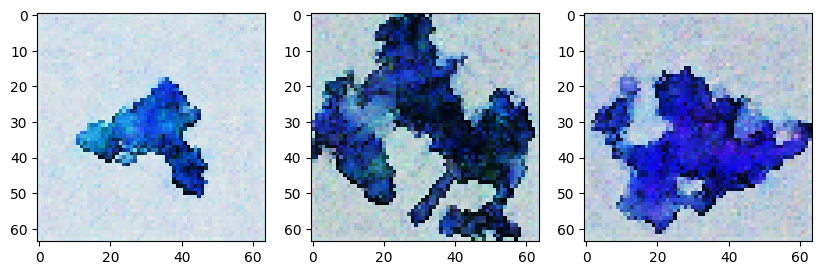

0.02825071:   7%|▋         | 6999/100001 [10:08<2:12:23, 11.71it/s]

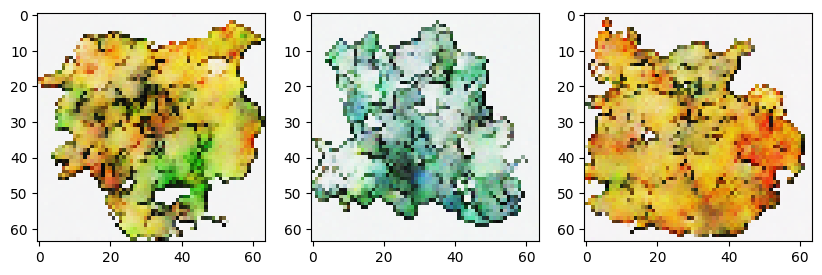

0.01631092:   8%|▊         | 7999/100001 [11:35<2:10:58, 11.71it/s]

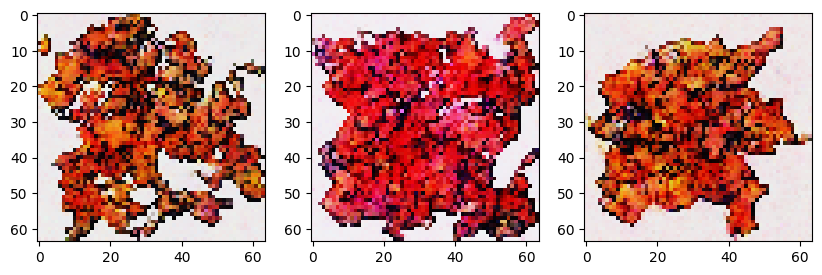

0.02384286:   9%|▉         | 8999/100001 [13:02<2:09:30, 11.71it/s]

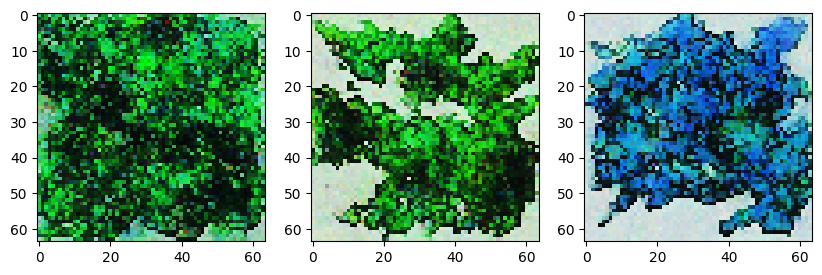

0.02334082:  10%|▉         | 9999/100001 [14:29<2:08:09, 11.71it/s]

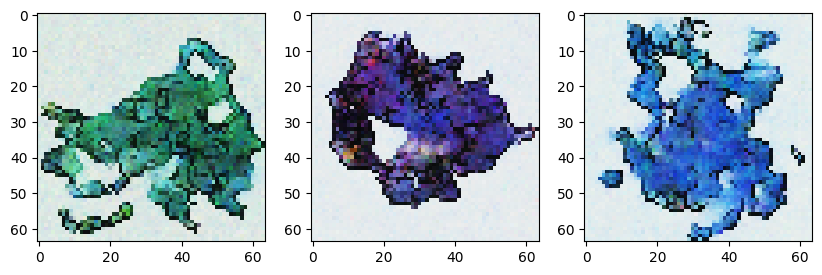

0.01929795:  11%|█         | 10999/100001 [15:56<2:06:43, 11.71it/s]

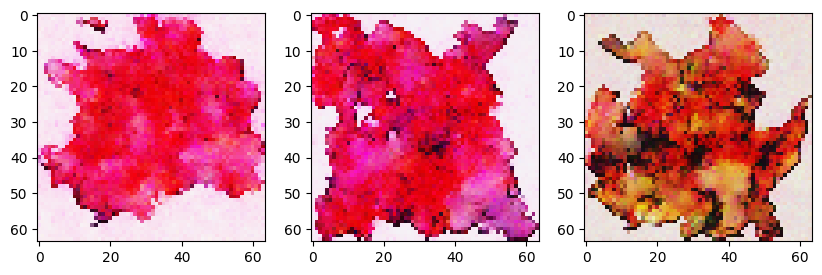

0.05094598:  12%|█▏        | 11999/100001 [17:22<2:05:15, 11.71it/s]

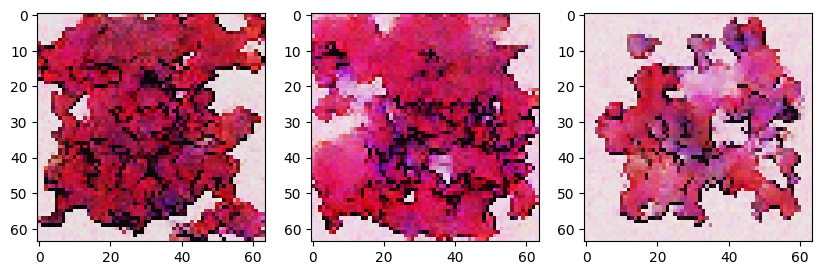

0.02759369:  13%|█▎        | 12999/100001 [18:49<2:03:49, 11.71it/s]

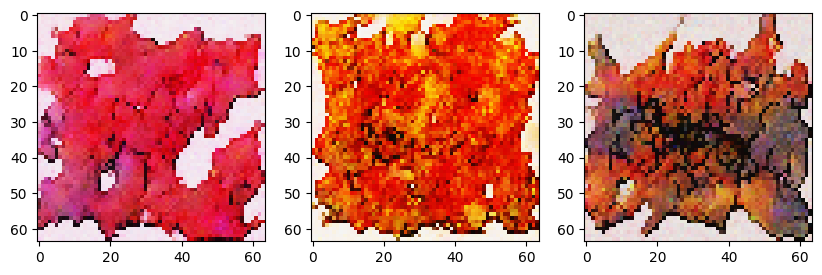

0.04611446:  14%|█▍        | 13999/100001 [20:16<2:02:29, 11.70it/s]

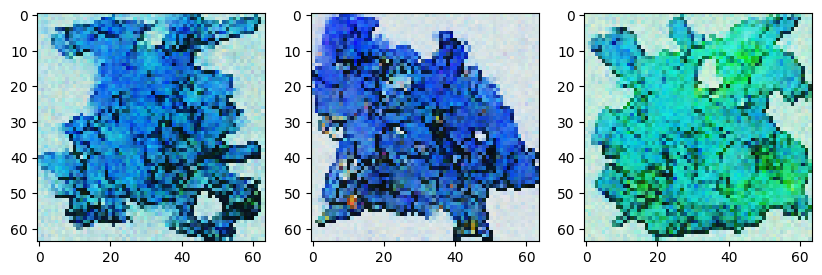

0.02245861:  15%|█▍        | 14999/100001 [21:43<2:01:06, 11.70it/s]

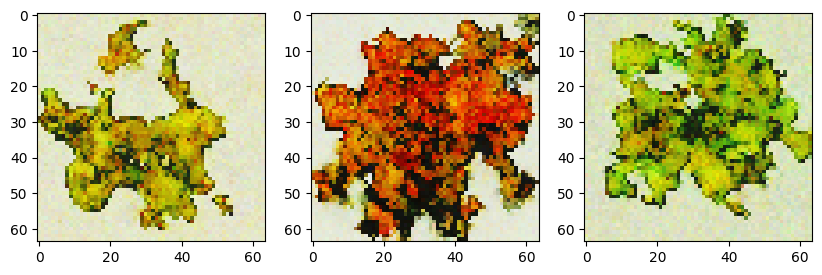

0.01747917:  16%|█▌        | 15999/100001 [23:10<1:59:37, 11.70it/s]

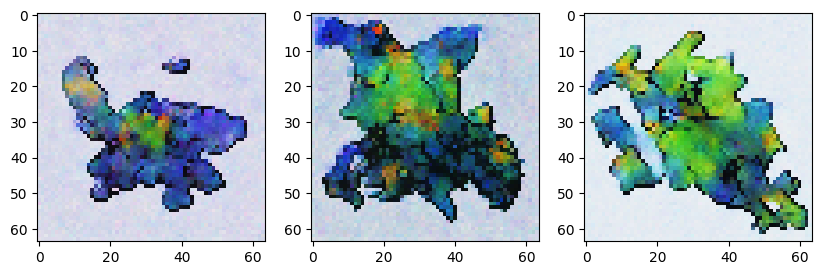

0.03472603:  17%|█▋        | 16999/100001 [24:37<1:58:09, 11.71it/s]

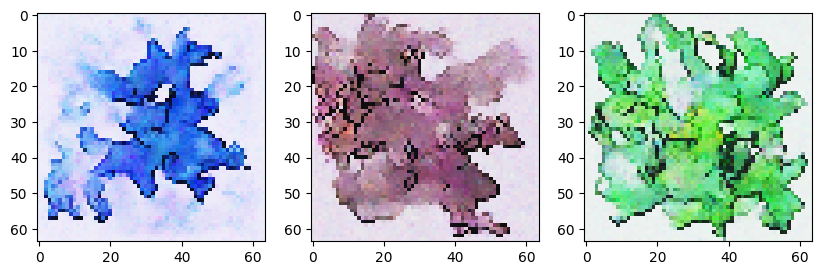

0.02335230:  18%|█▊        | 17999/100001 [26:04<1:56:51, 11.70it/s]

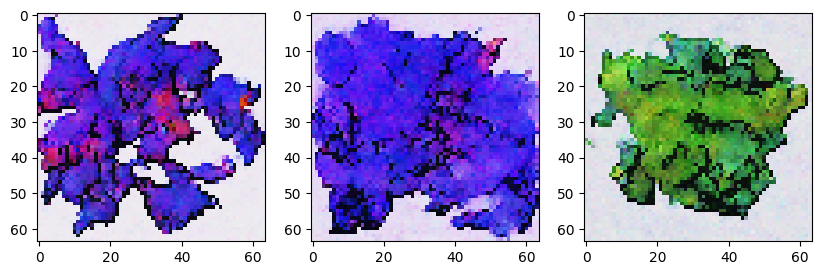

0.02898255:  19%|█▉        | 18999/100001 [27:31<1:55:26, 11.69it/s]

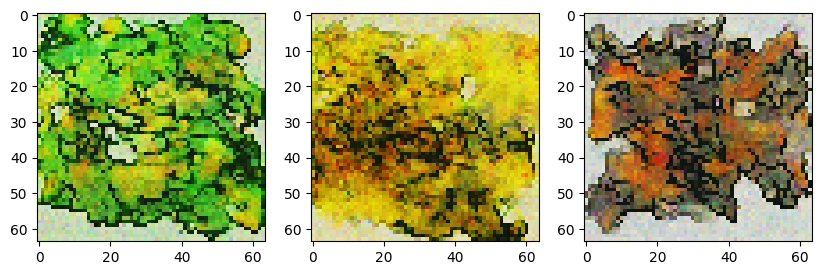

0.01480485:  20%|█▉        | 19999/100001 [28:58<1:54:00, 11.69it/s]

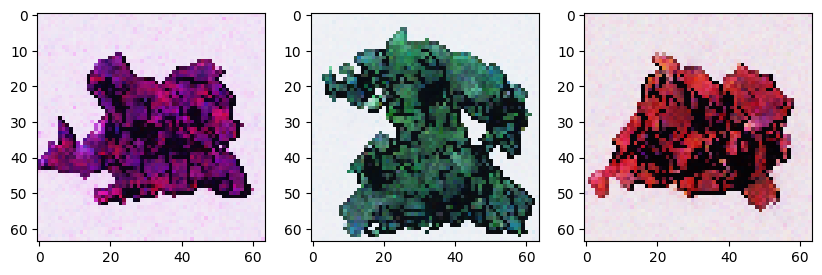

0.01986464:  21%|██        | 20999/100001 [30:25<1:52:15, 11.73it/s]

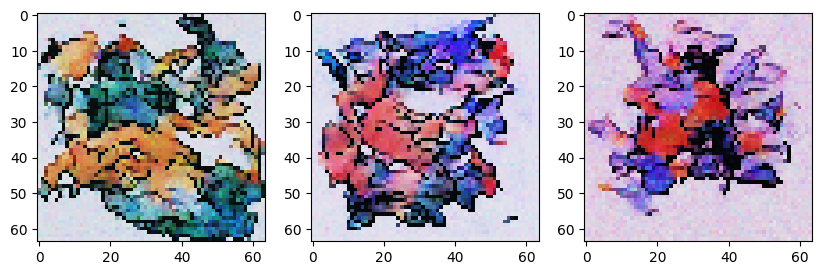

0.03124816:  22%|██▏       | 21999/100001 [31:52<1:51:16, 11.68it/s]

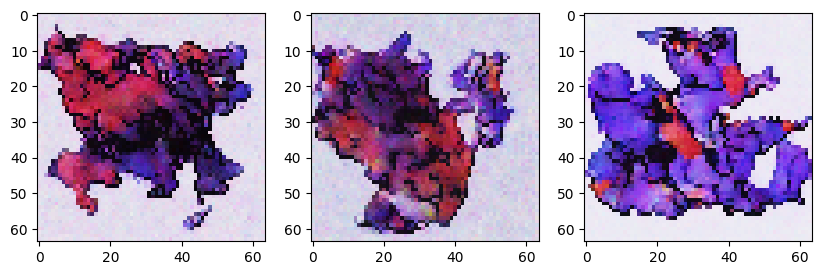

0.02068296:  23%|██▎       | 22999/100001 [33:19<1:49:42, 11.70it/s]

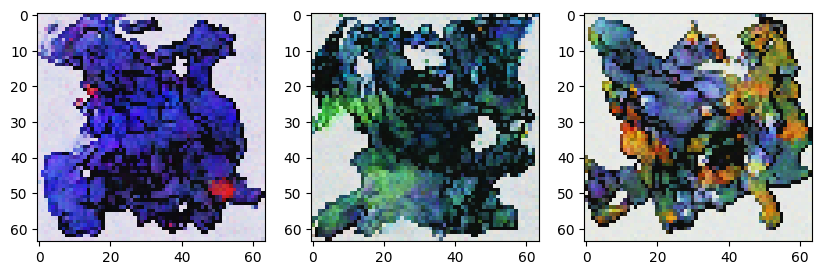

0.01670250:  24%|██▍       | 23999/100001 [34:46<1:48:19, 11.69it/s]

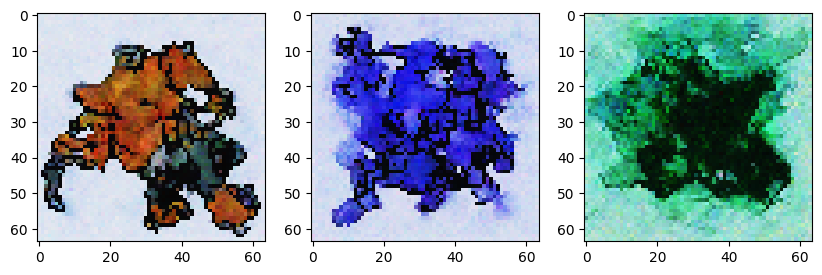

0.03053411:  25%|██▍       | 24999/100001 [36:12<1:46:45, 11.71it/s]

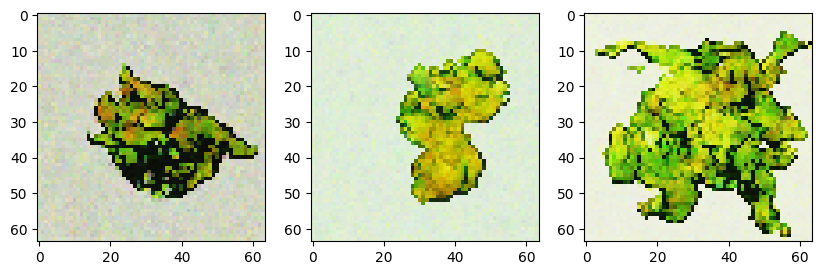

0.01984538:  26%|██▌       | 25999/100001 [37:39<1:45:26, 11.70it/s]

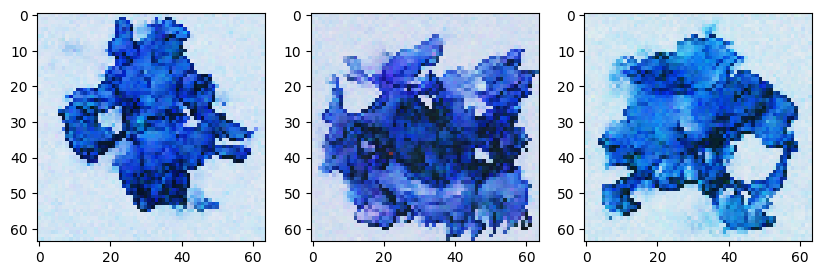

0.01437573:  27%|██▋       | 26999/100001 [39:06<1:43:56, 11.71it/s]

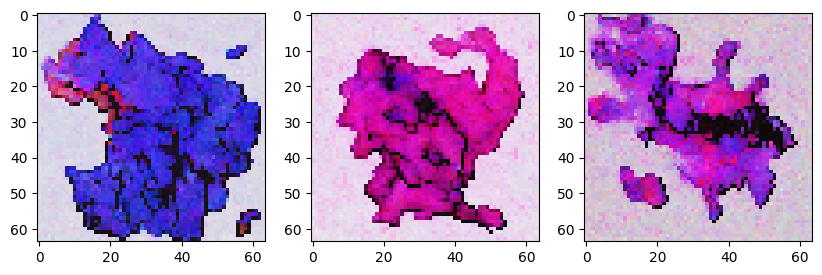

0.02276599:  28%|██▊       | 27999/100001 [40:33<1:42:31, 11.70it/s]

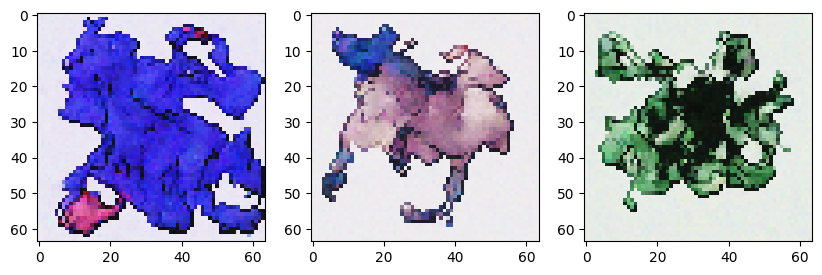

0.00589529:  29%|██▉       | 28999/100001 [42:00<1:41:13, 11.69it/s]

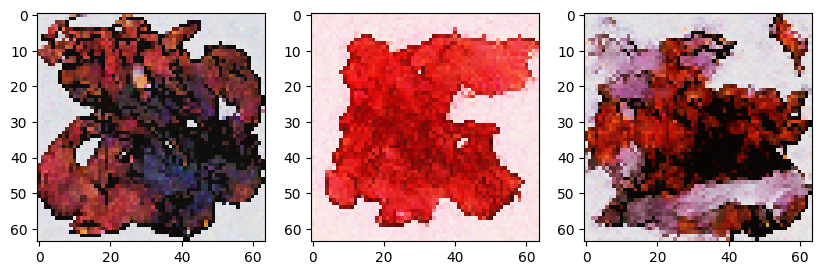

0.01583306:  30%|██▉       | 29999/100001 [43:27<1:39:44, 11.70it/s]

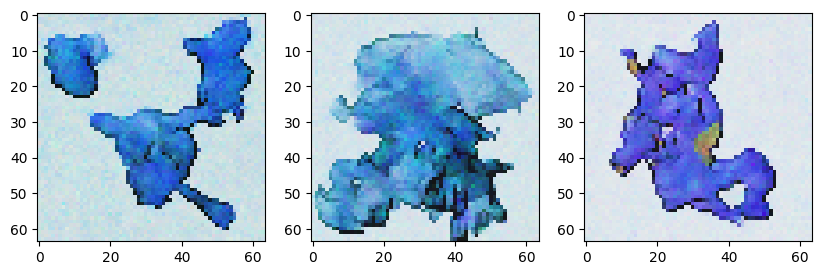

0.01428096:  31%|███       | 30999/100001 [44:54<1:38:24, 11.69it/s]

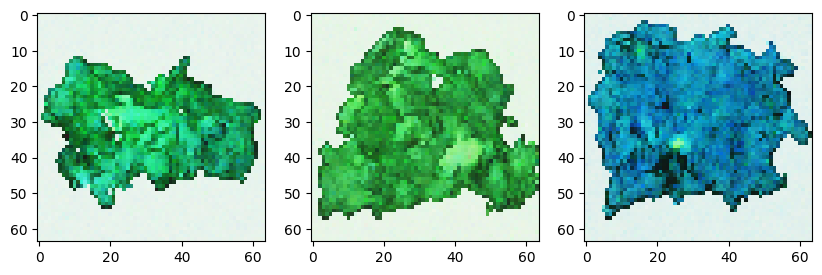

0.01296432:  32%|███▏      | 31999/100001 [46:21<1:36:53, 11.70it/s]

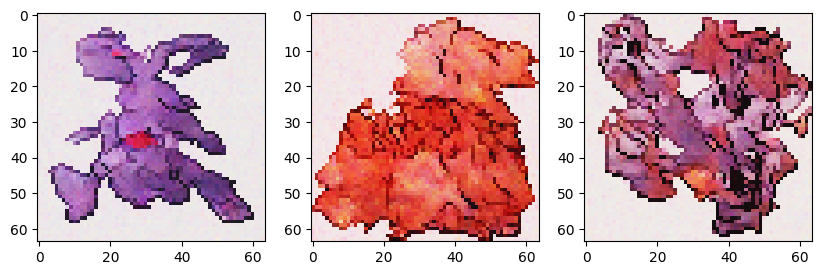

0.01977262:  33%|███▎      | 32999/100001 [47:48<1:35:30, 11.69it/s]

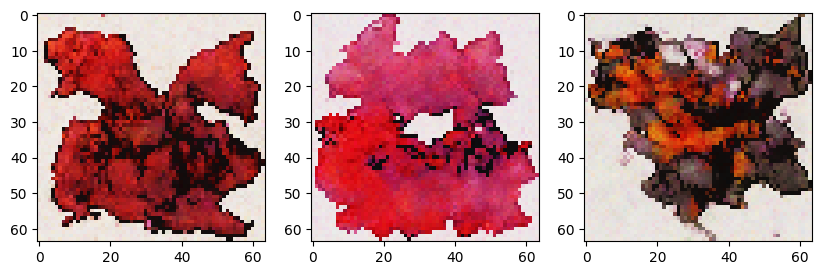

0.03186744:  34%|███▍      | 33999/100001 [49:15<1:33:54, 11.71it/s]

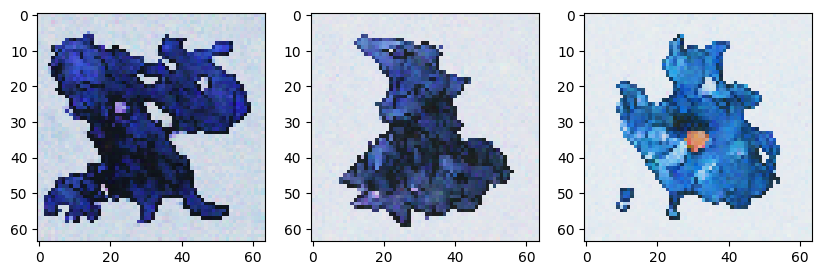

0.02034335:  35%|███▍      | 34999/100001 [50:42<1:32:37, 11.70it/s]

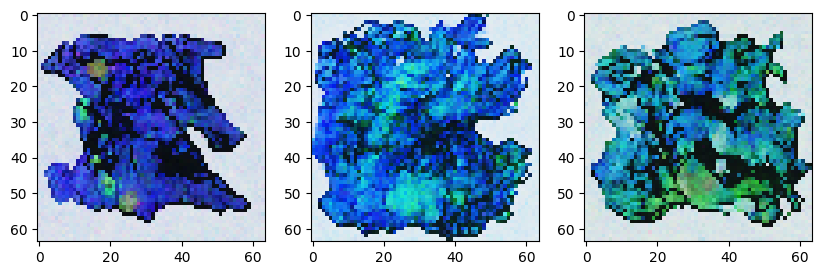

0.00947781:  36%|███▌      | 35999/100001 [52:09<1:31:19, 11.68it/s]

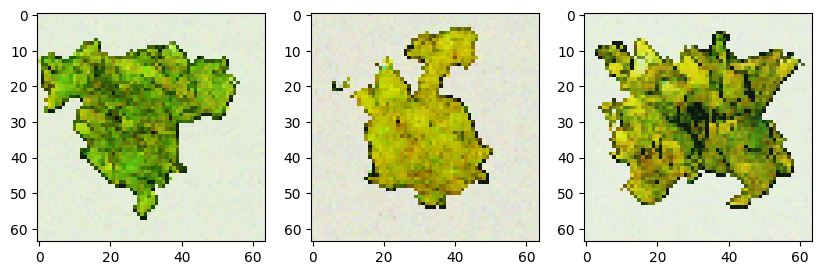

0.02324071:  37%|███▋      | 36999/100001 [53:36<1:29:49, 11.69it/s]

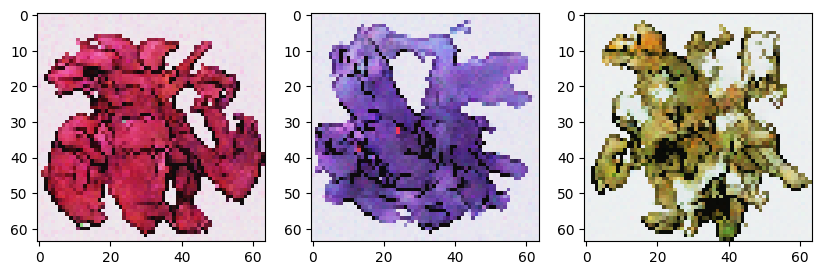

0.01336441:  38%|███▊      | 37999/100001 [55:03<1:28:20, 11.70it/s]

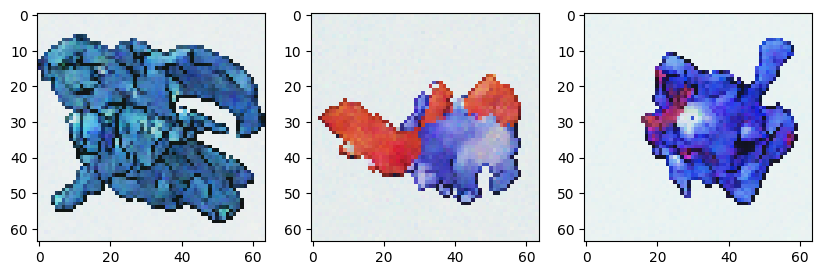

0.01562805:  39%|███▉      | 38999/100001 [56:30<1:26:55, 11.70it/s]

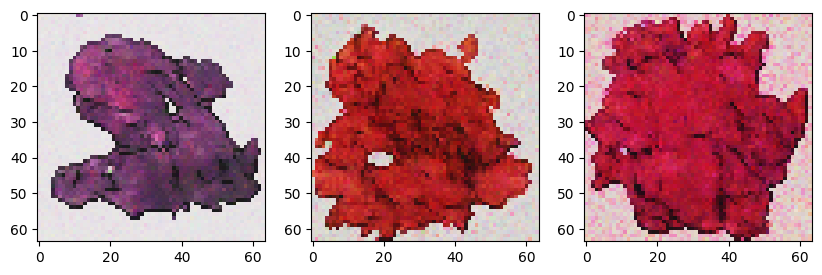

0.02076194:  40%|███▉      | 39999/100001 [57:57<1:25:31, 11.69it/s]

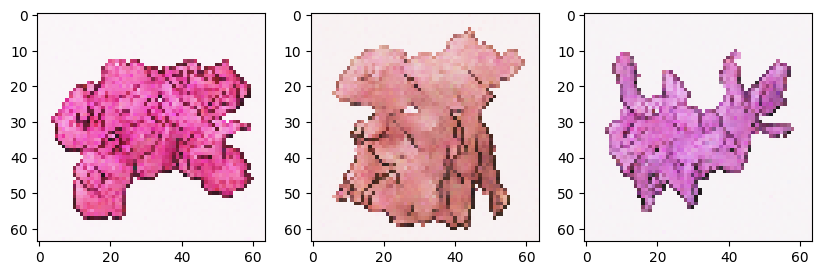

0.02388261:  41%|████      | 40999/100001 [59:24<1:24:01, 11.70it/s]

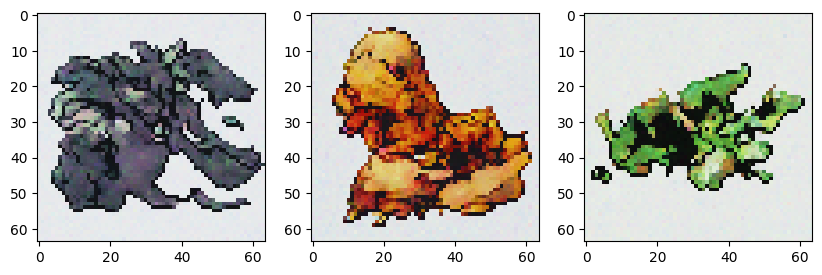

0.01637316:  42%|████▏     | 41999/100001 [1:00:51<1:22:42, 11.69it/s]

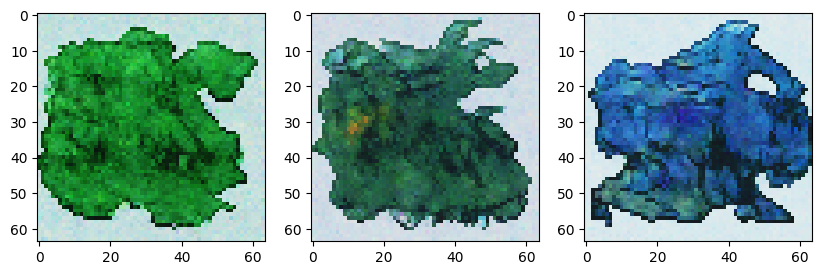

0.01901896:  43%|████▎     | 42999/100001 [1:02:18<1:21:16, 11.69it/s]

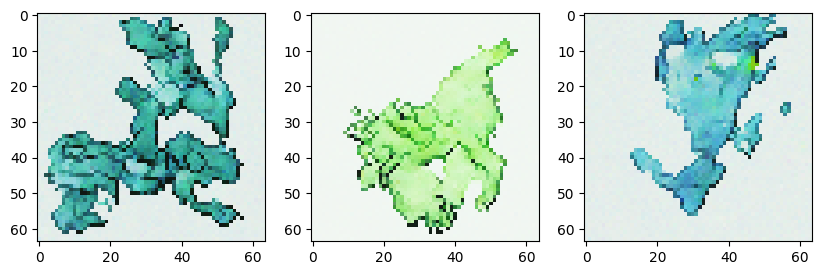

0.00960948:  44%|████▍     | 43999/100001 [1:03:45<1:19:45, 11.70it/s]

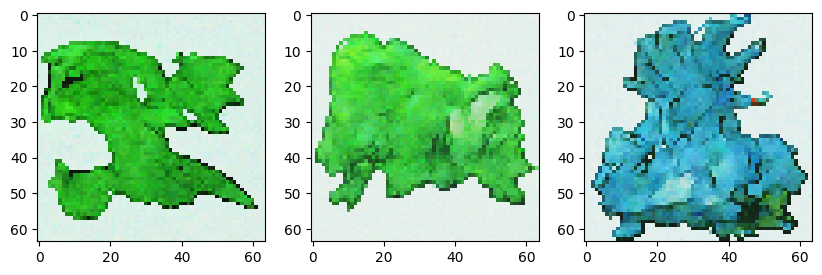

0.01452007:  45%|████▍     | 44999/100001 [1:05:12<1:18:26, 11.69it/s]

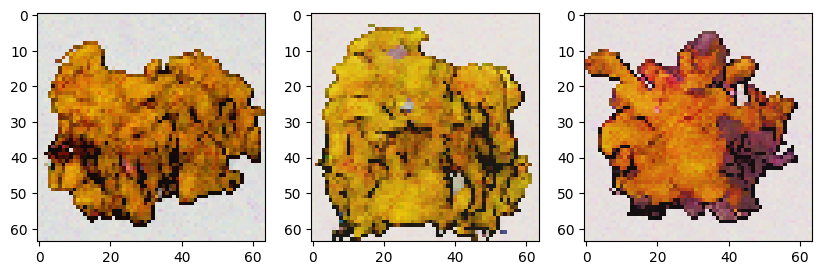

0.01243544:  46%|████▌     | 45999/100001 [1:06:39<1:16:52, 11.71it/s]

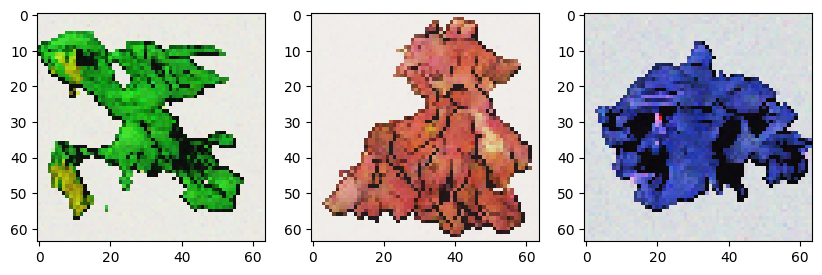

0.00738865:  47%|████▋     | 46999/100001 [1:08:06<1:15:31, 11.70it/s]

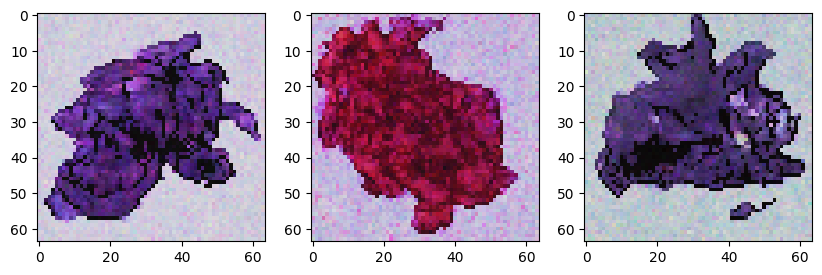

0.03535363:  48%|████▊     | 47999/100001 [1:09:33<1:13:48, 11.74it/s]

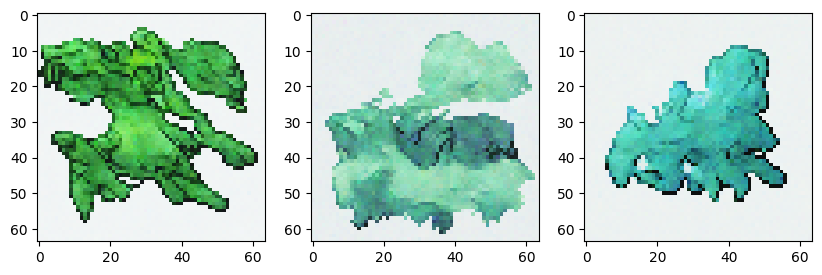

0.01820634:  49%|████▉     | 48999/100001 [1:11:00<1:12:32, 11.72it/s]

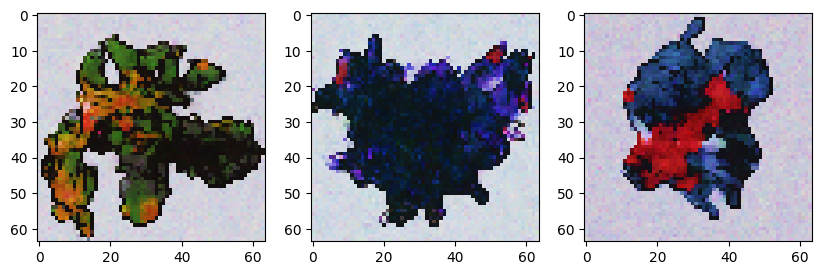

0.01513350:  50%|████▉     | 49999/100001 [1:12:26<1:11:15, 11.69it/s]

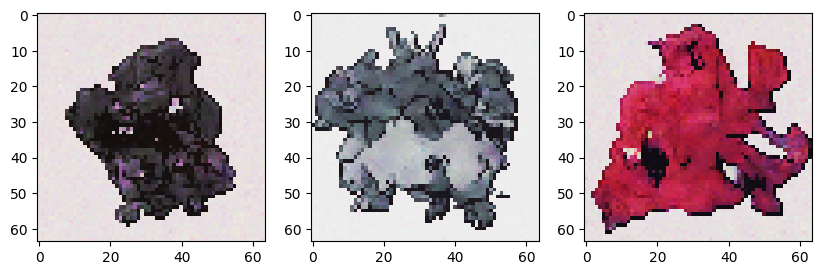

0.02441658:  51%|█████     | 50999/100001 [1:13:53<1:09:45, 11.71it/s]

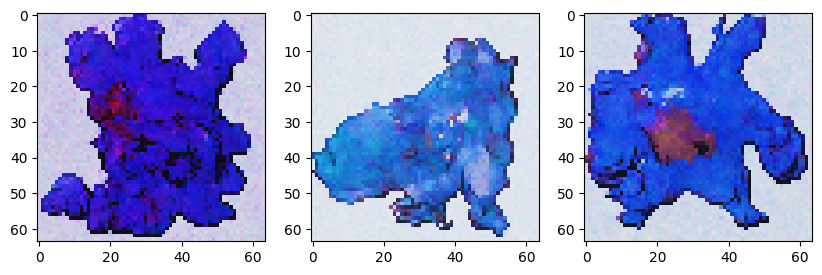

0.00734092:  52%|█████▏    | 51999/100001 [1:15:20<1:08:21, 11.70it/s]

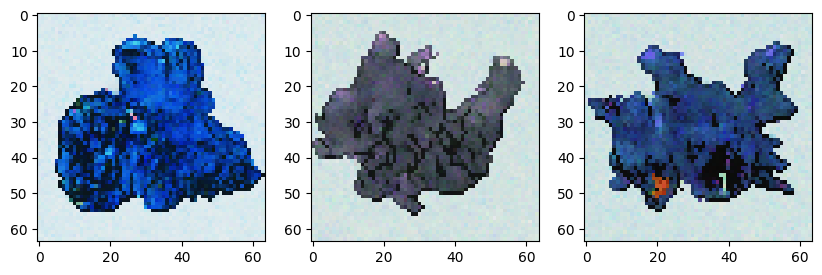

0.00669497:  53%|█████▎    | 52999/100001 [1:16:47<1:07:00, 11.69it/s]

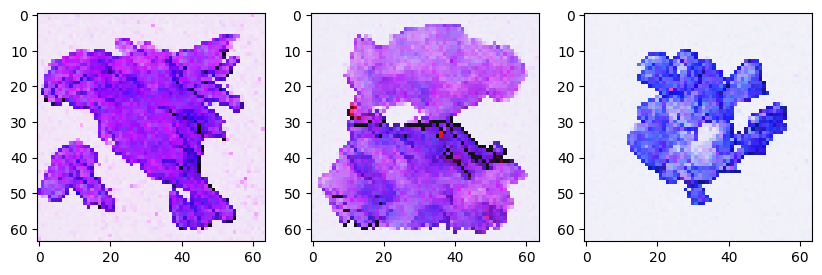

0.01005194:  54%|█████▍    | 53999/100001 [1:18:14<1:05:35, 11.69it/s]

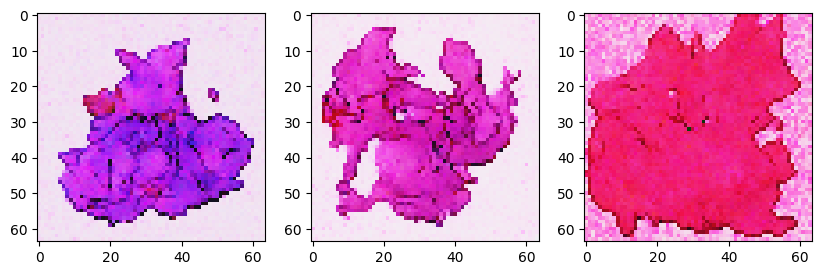

0.01279001:  55%|█████▍    | 54999/100001 [1:19:41<1:04:08, 11.69it/s]

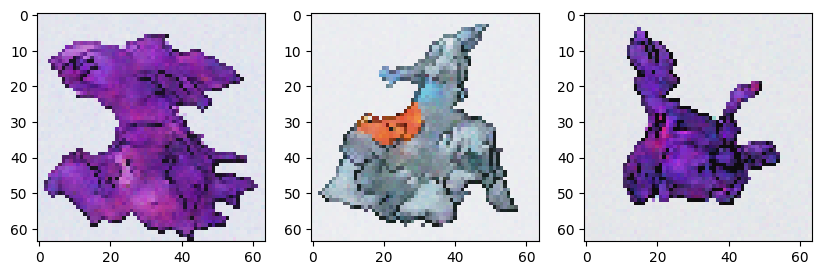

0.01958600:  56%|█████▌    | 55999/100001 [1:21:08<1:02:40, 11.70it/s]

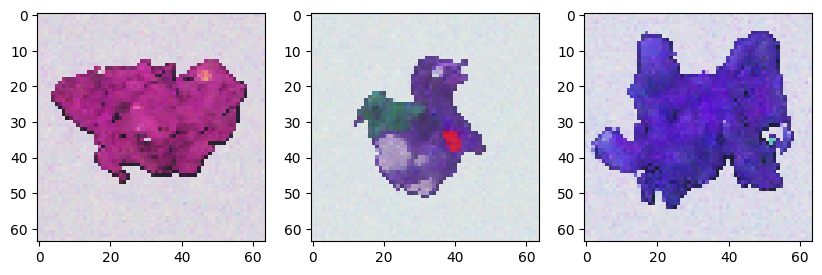

0.01909981:  57%|█████▋    | 56999/100001 [1:22:35<1:01:17, 11.69it/s]

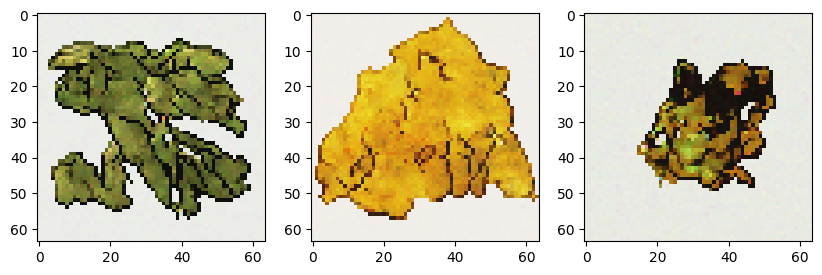

0.01190585:  58%|█████▊    | 57999/100001 [1:24:02<59:50, 11.70it/s]  

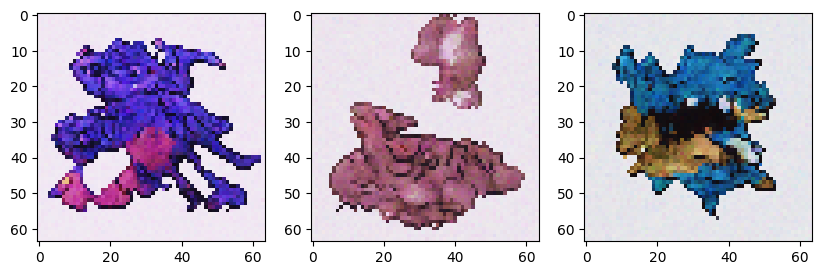

0.01788515:  59%|█████▉    | 58999/100001 [1:25:29<58:25, 11.70it/s]  

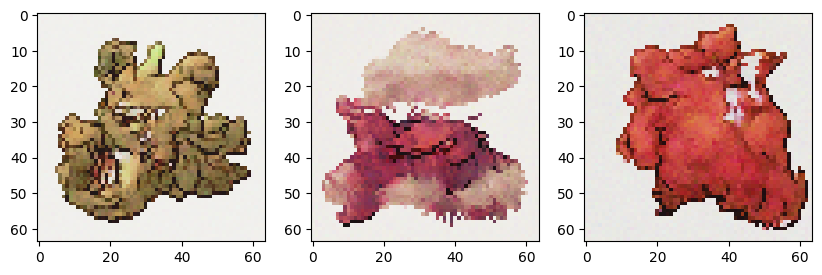

0.02444135:  60%|█████▉    | 59999/100001 [1:26:56<56:53, 11.72it/s]  

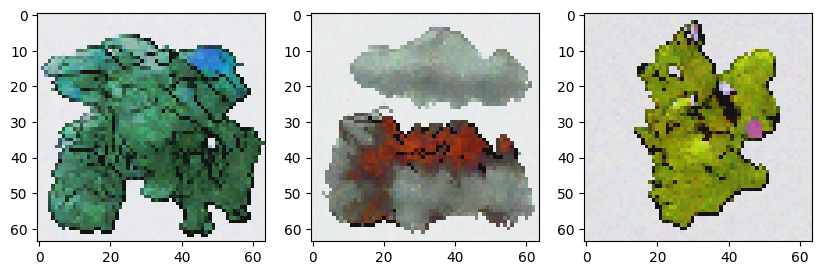

0.01390756:  61%|██████    | 60999/100001 [1:28:23<55:31, 11.71it/s]  

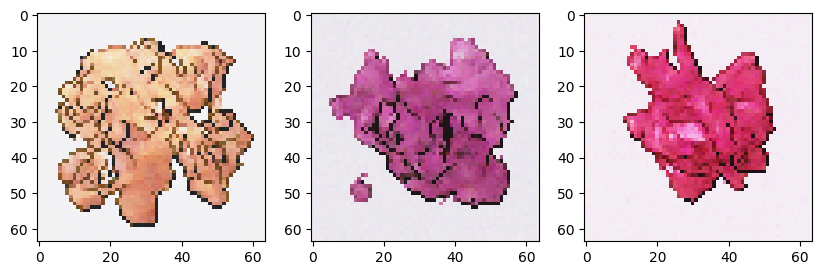

0.01807303:  62%|██████▏   | 61999/100001 [1:29:50<54:03, 11.72it/s]  

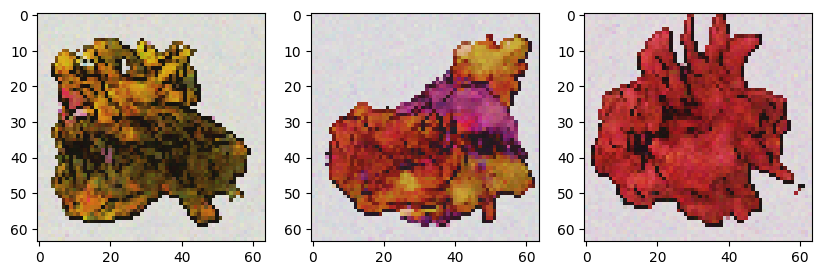

0.01746704:  63%|██████▎   | 62999/100001 [1:31:17<52:41, 11.70it/s]  

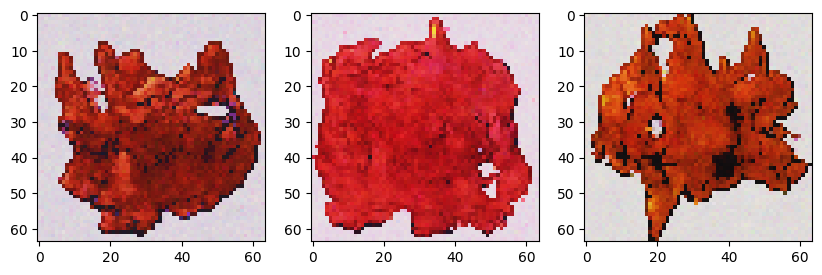

0.00614816:  64%|██████▍   | 63999/100001 [1:32:44<51:15, 11.70it/s]  

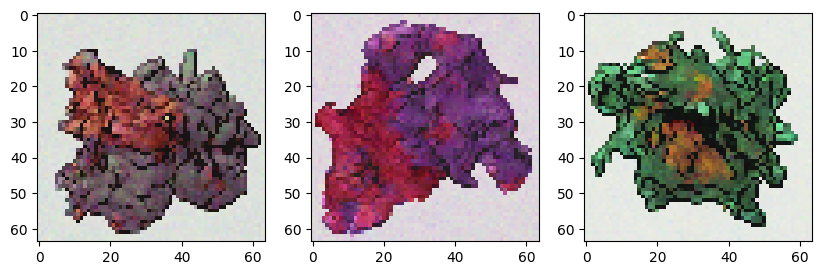

0.02610484:  65%|██████▍   | 64999/100001 [1:34:11<49:48, 11.71it/s]  

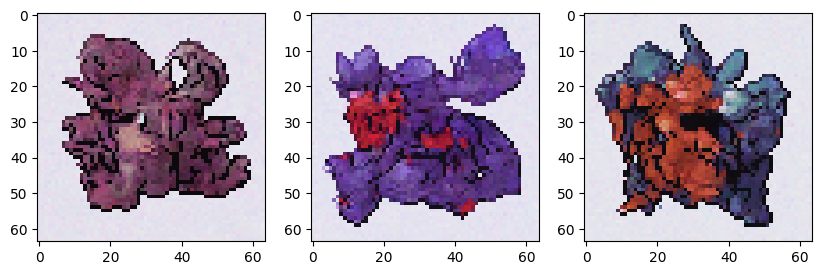

0.01552616:  66%|██████▌   | 65999/100001 [1:35:38<48:25, 11.70it/s]  

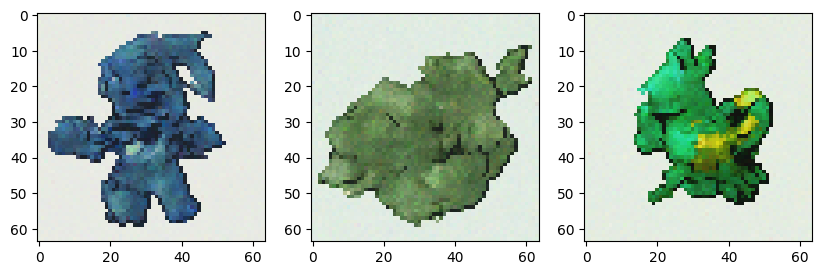

0.02328158:  67%|██████▋   | 66999/100001 [1:37:05<47:03, 11.69it/s]  

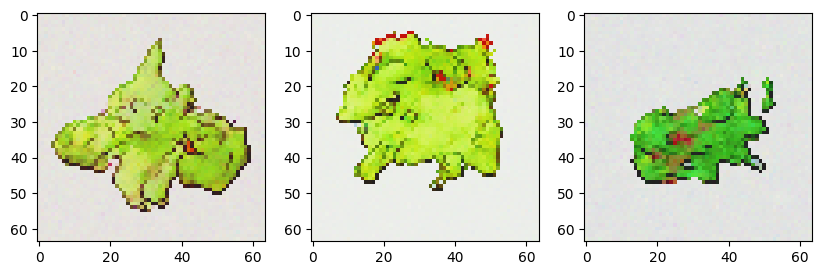

0.01600583:  68%|██████▊   | 67999/100001 [1:38:31<45:33, 11.71it/s]  

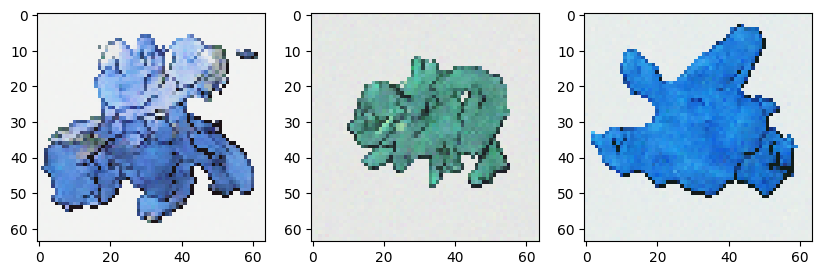

0.02020602:  69%|██████▉   | 68999/100001 [1:39:58<44:12, 11.69it/s]  

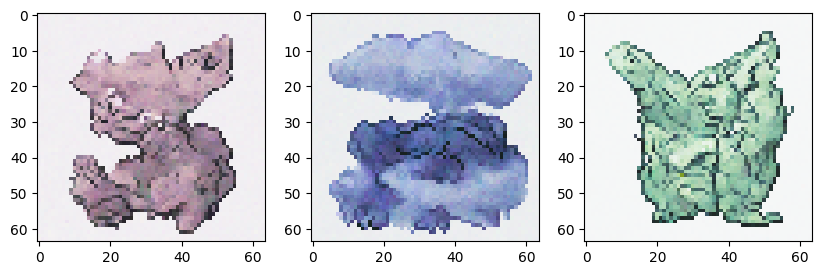

0.01473389:  70%|██████▉   | 69999/100001 [1:41:25<42:39, 11.72it/s]  

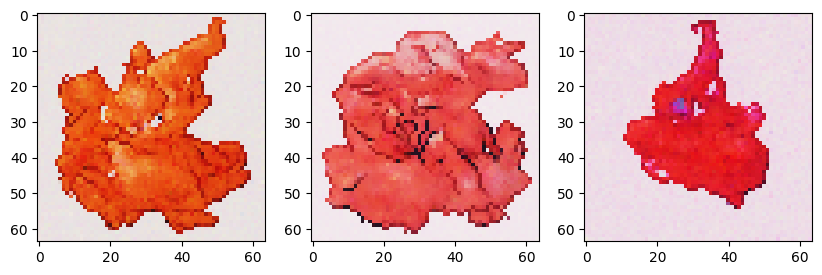

0.01172141:  71%|███████   | 70999/100001 [1:42:52<41:18, 11.70it/s]  

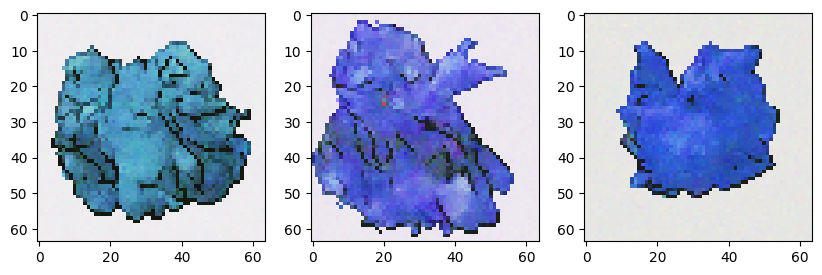

0.00987055:  72%|███████▏  | 71999/100001 [1:44:19<39:55, 11.69it/s]  

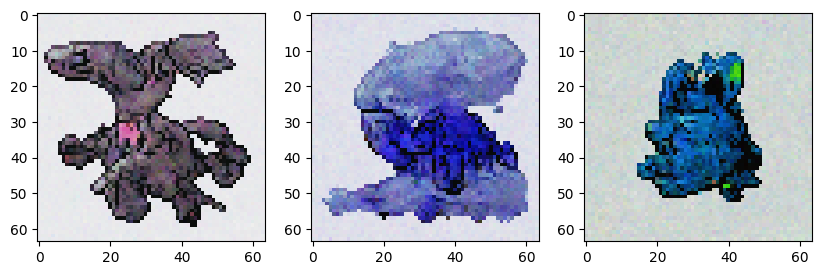

0.01960248:  73%|███████▎  | 72999/100001 [1:45:46<38:30, 11.69it/s]  

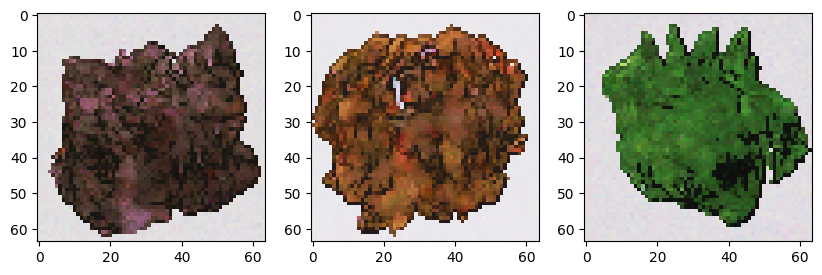

0.01508033:  74%|███████▍  | 73999/100001 [1:47:13<37:00, 11.71it/s]  

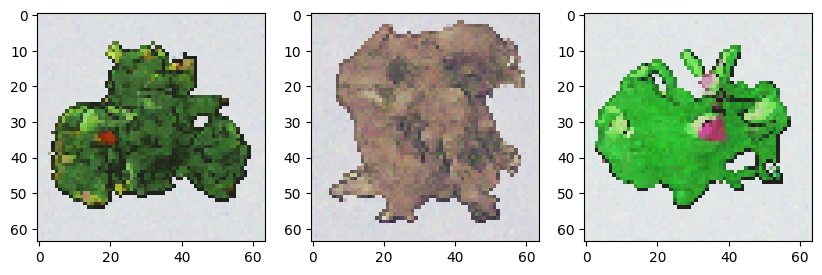

0.03121710:  75%|███████▍  | 74999/100001 [1:48:40<35:39, 11.69it/s]  

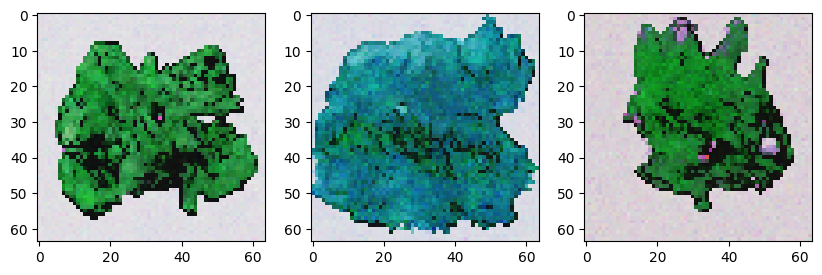

0.01355751:  76%|███████▌  | 75999/100001 [1:50:07<34:14, 11.68it/s]  

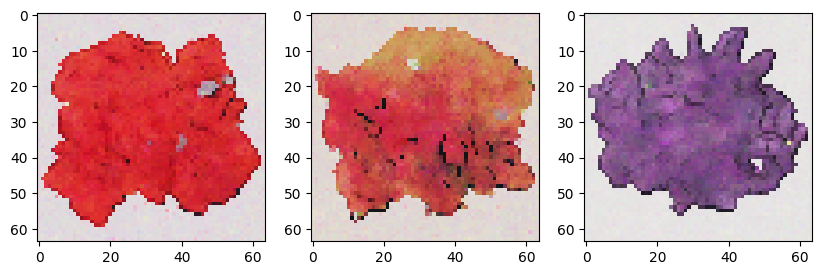

0.00552147:  77%|███████▋  | 76999/100001 [1:51:34<32:47, 11.69it/s]  

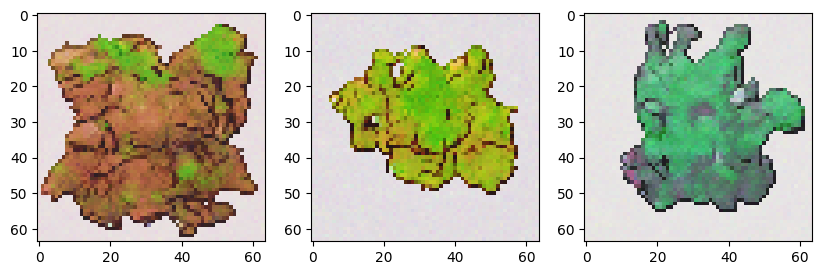

0.02260380:  78%|███████▊  | 77999/100001 [1:53:01<31:17, 11.72it/s]  

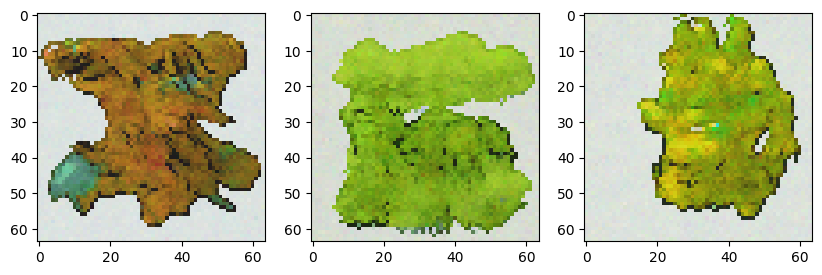

0.01486066:  79%|███████▉  | 78999/100001 [1:54:28<29:54, 11.70it/s]  

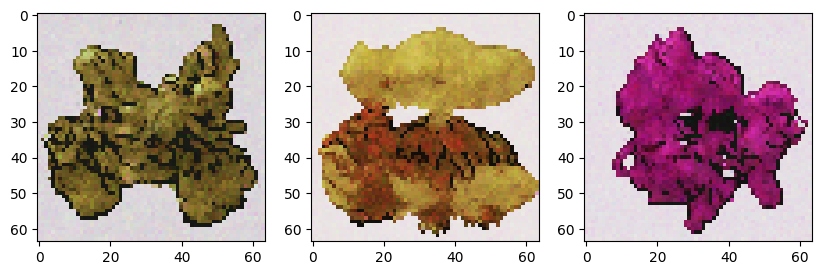

0.00994613:  80%|███████▉  | 79999/100001 [1:55:55<28:28, 11.71it/s]  

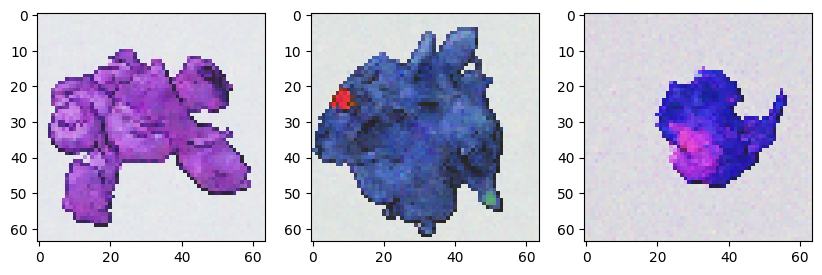

0.00948714:  81%|████████  | 80999/100001 [1:57:22<27:03, 11.70it/s]  

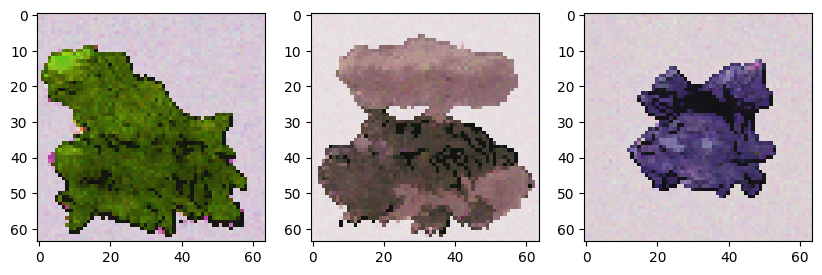

0.02090510:  82%|████████▏ | 81999/100001 [1:58:49<25:36, 11.71it/s]  

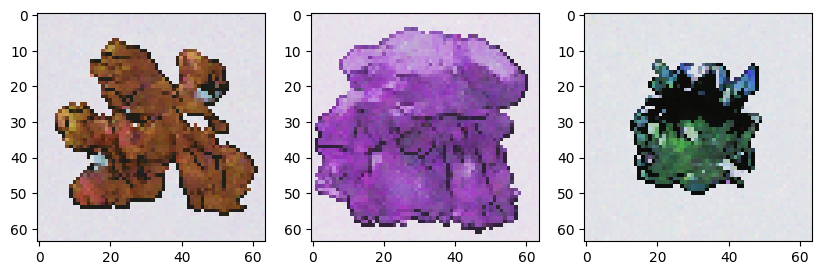

0.02131701:  83%|████████▎ | 82999/100001 [2:00:16<24:12, 11.70it/s]  

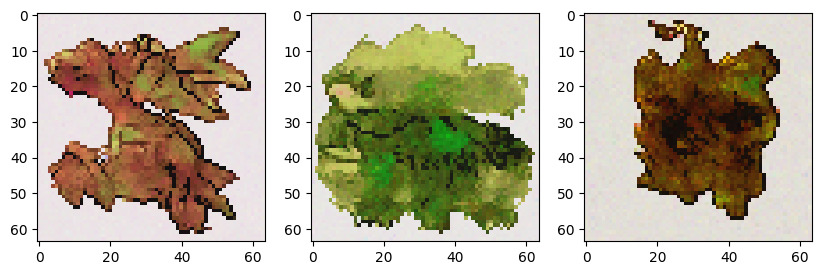

0.01616152:  84%|████████▍ | 83999/100001 [2:01:43<22:47, 11.70it/s]  

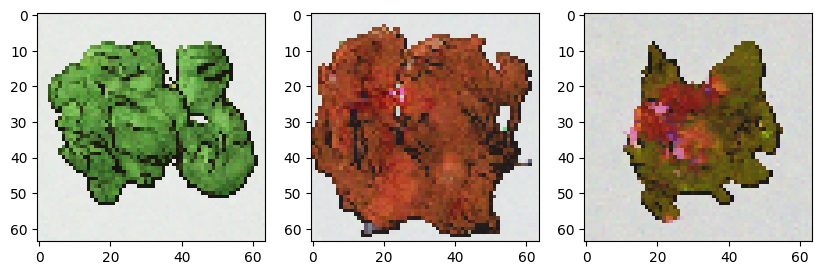

0.01267369:  85%|████████▍ | 84999/100001 [2:03:10<21:21, 11.71it/s]  

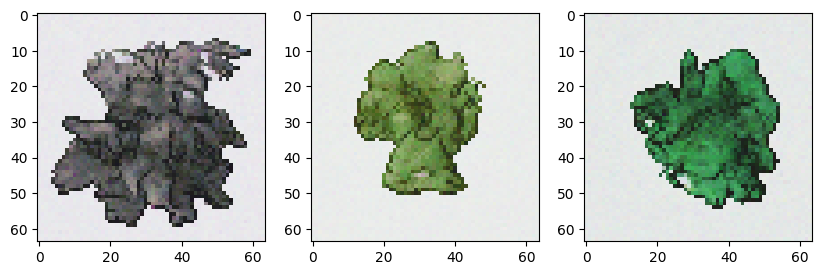

0.01062151:  86%|████████▌ | 85999/100001 [2:04:37<19:55, 11.71it/s]  

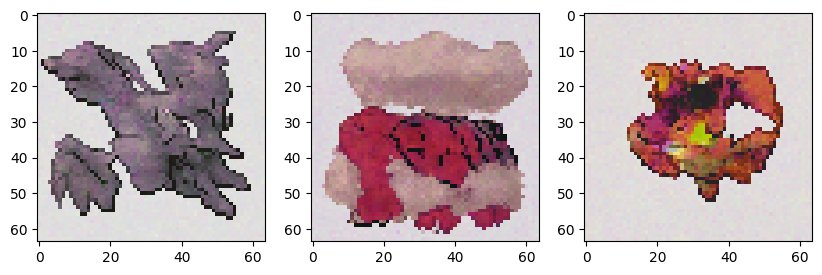

0.03606825:  87%|████████▋ | 86999/100001 [2:06:04<18:30, 11.71it/s]  

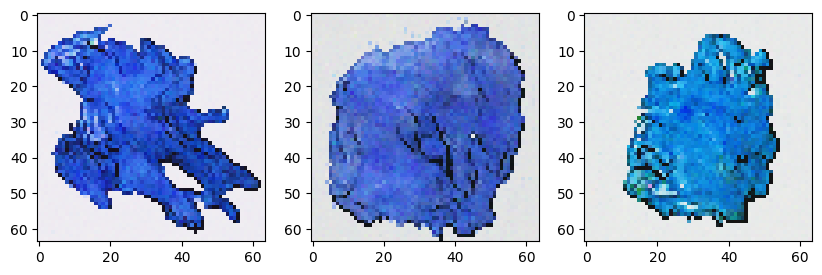

0.01073627:  88%|████████▊ | 87999/100001 [2:07:30<17:06, 11.69it/s]  

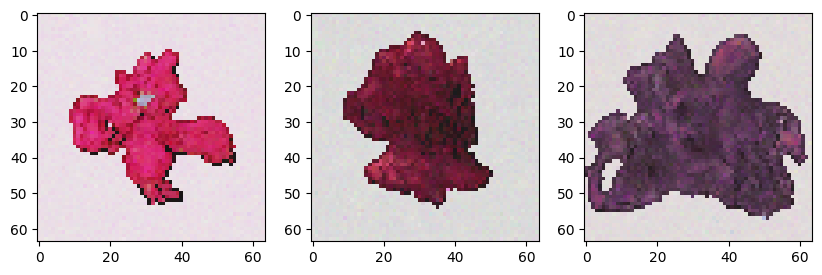

0.01001695:  89%|████████▉ | 88999/100001 [2:08:57<15:40, 11.70it/s]  

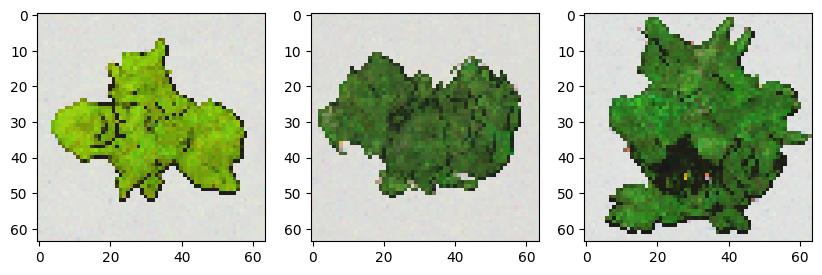

0.01055530:  90%|████████▉ | 89999/100001 [2:10:24<14:15, 11.70it/s]

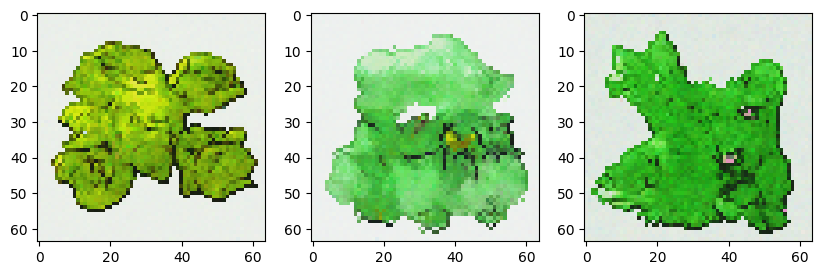

0.00525072:  91%|█████████ | 90999/100001 [2:11:51<12:49, 11.70it/s]

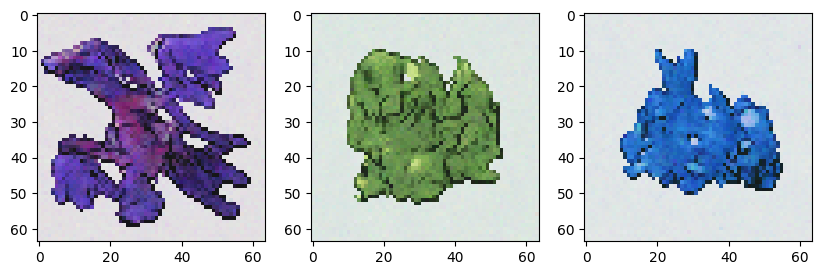

0.01288994:  92%|█████████▏| 91999/100001 [2:13:18<11:23, 11.70it/s]

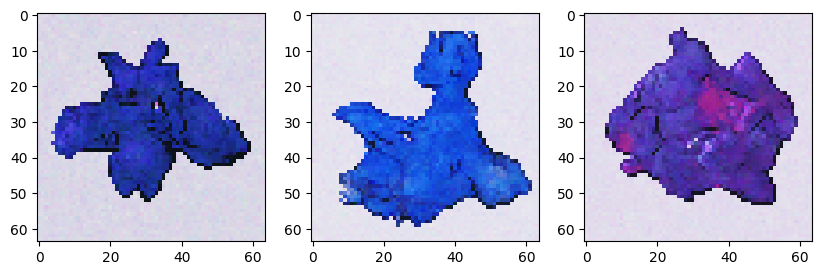

0.01423581:  93%|█████████▎| 92999/100001 [2:14:45<09:59, 11.69it/s]

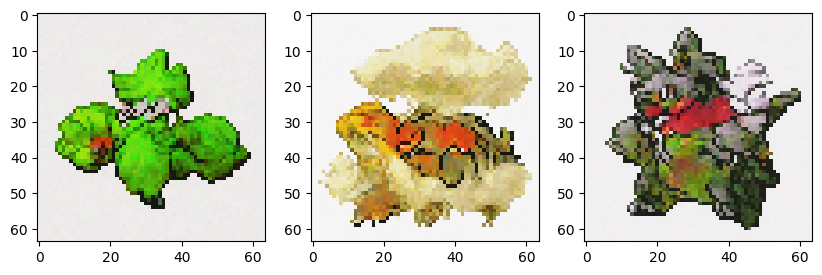

0.01229030:  94%|█████████▍| 93999/100001 [2:16:12<08:34, 11.68it/s]

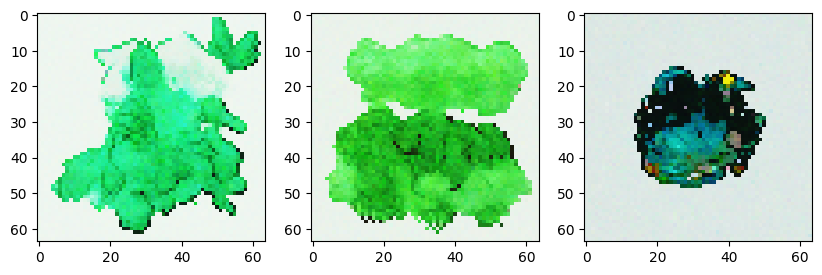

0.02006837:  95%|█████████▍| 94999/100001 [2:17:39<07:07, 11.71it/s]

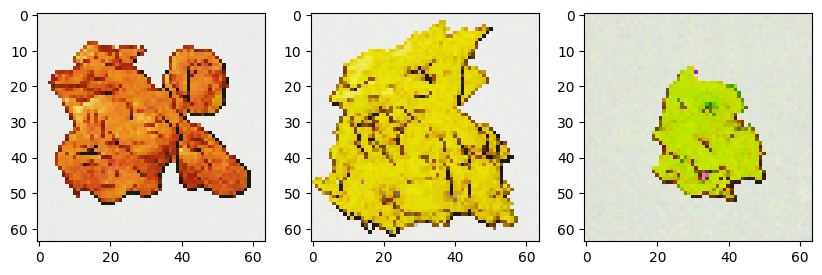

0.02432236:  96%|█████████▌| 95999/100001 [2:19:06<05:41, 11.71it/s]

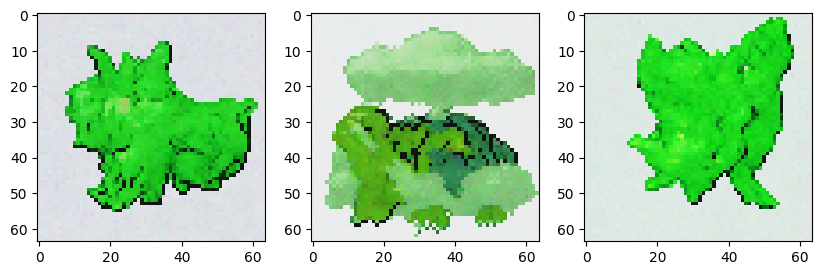

0.01432022:  97%|█████████▋| 96999/100001 [2:20:33<04:16, 11.72it/s]

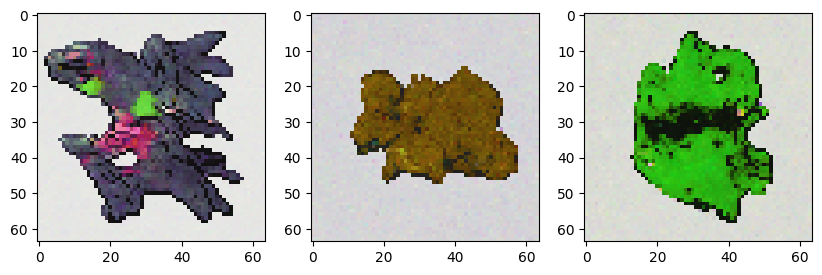

0.01922782:  98%|█████████▊| 97999/100001 [2:22:00<02:50, 11.71it/s]

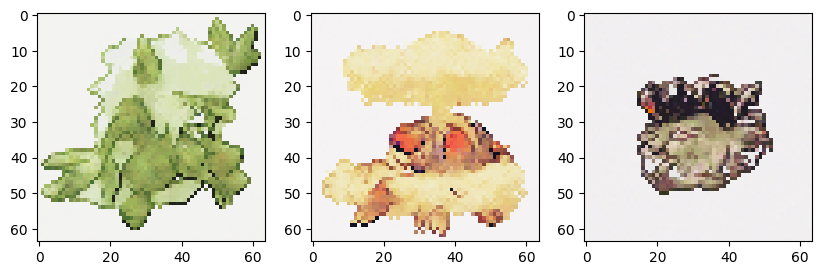

0.02046425:  99%|█████████▉| 98999/100001 [2:23:27<01:25, 11.69it/s]

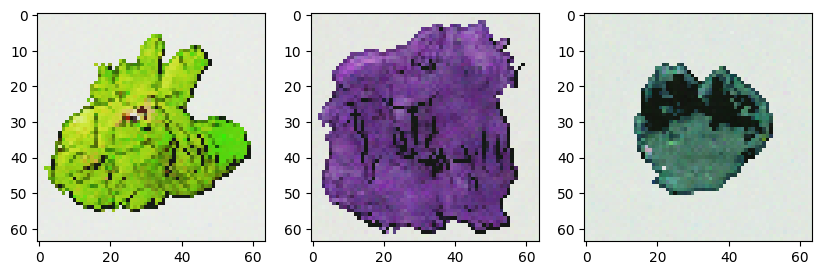

0.00691123: 100%|█████████▉| 99999/100001 [2:24:53<00:00, 11.71it/s]

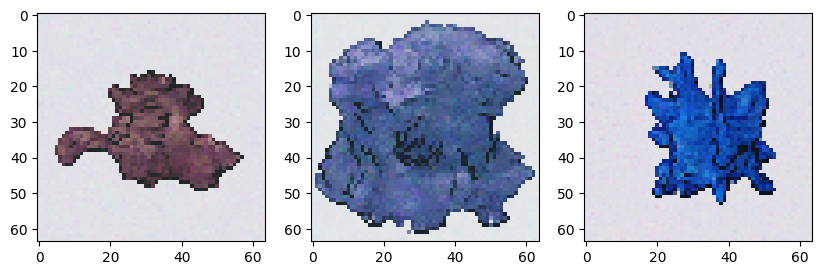

0.02210247: 100%|██████████| 100001/100001 [2:24:55<00:00, 11.50it/s]


In [10]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    h = height[batch]
    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, h, ty)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')